# To Do List

~~1) Load data~~

~~2) Load metadata~~

3) Clean metadata

4) Make a function to subset time from data for transform

5) Figure out where normalization should be implemented

6) Figure out how to group spectra from different trials

7) Implement statistics on grouped spectra

# Erin Suggestions to do list

Make an example input coding csv for greg to practice with

Send it to greg to see if it is useful

Build pipeline to merge indicator sheet with dataset

Give concrete timelines for when we can get something done

be very specific "we need to have this amount/type of data by this date. If not here is plan B"

Bottomline, make sure greg has a-oked a workflow he can do in 30 seconds with a timeline

One possible thing to do with the is there an error senario is to do GPT call via API. Con of this is it is not obvious if this advances goal

One possible workflow split: Sam does data cleaning from metadata, Nick gets Greg to do the indicator variable input

Meet more the two of us and figure out our work dynamic, for example weekly check-in for team building purposes

A good consulting trick is to say "ok I am hearing X. What part or percent of the paper/project does this represent? Alternatively where does this slot into the overall project?" This is actually a great opportunity to hear the client say the same thing in different words or from a different angle

Another good focus is to find out if Greg has a journal in mind as this can give us a format to focus on

# Data Load

In [1]:
import mne, os
import xml.etree.ElementTree as ET
from matplotlib import pyplot as plt

In [2]:
data_root = os.path.join(os.getcwd(), 'Examples2024', '00000016-APDx20974')
data_path = os.path.join(data_root, '00000016-APDx20974[001].edf')
meta_path = os.path.join(data_root, '00000016-APDx20974.rml')

In [3]:
# Load an EDF file
raw = mne.io.read_raw_edf(data_path, preload=True)

# Print information about the file
print(raw.info)

# Print all channel names to review them
print(raw.info['ch_names'])

# Subset to only EEG Channels and print general data
selected_channels = raw.pick(['EEG C3-A2', 'EEG C4-A1', 'EEG O1-A2', 'EEG O2-A1'])

display(selected_channels)

Extracting EDF parameters from /home/sam/Classes/Stats/Consulting/EEG_Consulting/Examples2024/00000016-APDx20974/00000016-APDx20974[001].edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9235599  =      0.000 ... 46177.995 secs...


/tmp/ipykernel_30684/1420070580.py:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'Flow Patient'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(data_path, preload=True)


<Info | 8 non-empty values
 bads: []
 ch_names: EEG C3-A2, EEG C4-A1, EEG O1-A2, EEG O2-A1, EMG Chin, EMG Aux1, ...
 chs: 17 EEG
 custom_ref_applied: False
 highpass: 0.3 Hz
 lowpass: 35.0 Hz
 meas_date: 2016-09-15 19:25:47 UTC
 nchan: 17
 projs: []
 sfreq: 200.0 Hz
 subject_info: 3 items (dict)
>
['EEG C3-A2', 'EEG C4-A1', 'EEG O1-A2', 'EEG O2-A1', 'EMG Chin', 'EMG Aux1', 'ECG V', 'Flow Patient-0', 'Flow Patient-1', 'Effort THO', 'Effort ABD', 'SpO2', 'Pleth', 'PulseRate', 'EEG A1-A2', 'PPG', 'Technical']


Measurement date,"September 15, 2016 19:25:47 GMT"
Experimenter,Unknown
Participant,X
Digitized points,Not available
Good channels,4 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,200.00 Hz
Highpass,0.30 Hz
Lowpass,35.00 Hz


Using matplotlib as 2D backend.


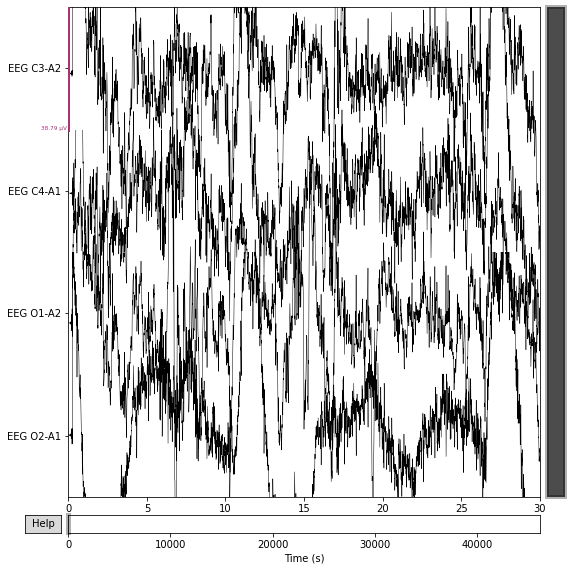

In [4]:
# Visualize the EEG time series for the selected channels
selected_channels.plot(start=0, duration=30, scalings='auto', title='Selected EEG Channels')
plt.show()

In [ ]:
# To visualize the multitaper spectral estimation
# Compute the Power Spectral Density (PSD) using the multitaper method
channel_names = ['EEG C3-A2']
selected_data = raw.copy().pick_channels(channel_names)
sfreq = selected_data.info['sfreq']
# Extract the data from the Raw object
data, times = selected_data[:, :]

psds, freqs = mne.time_frequency.psd_array_multitaper(data, sfreq=sfreq, fmin=0.1, fmax=40, adaptive=False, normalization='length', verbose=True)
# Plot the Power Spectral Density (PSD) for the selected EEG channels
plt.semilogy(freqs, psds.T, label='Multitaper PSD')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.title('Multitaper PSD for EEG C3-A2')
plt.xlim([0.1, 40])  # Adjust the frequency range as needed
plt.legend()
plt.show()


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


# Load Metadata

In [ ]:
def get_namespaces(file_path):
    """
    Parses the XML file and extracts namespaces as a dictionary.
    Namespaces in XML are declared in the root element or throughout the document.
    
    Args:
    - file_path: Path to the XML file.
    
    Returns:
    A dictionary with namespace prefixes as keys and URIs as values.
    """
    namespaces = {}
    for event, elem in ET.iterparse(file_path, events=('start-ns',)):
        prefix, uri = elem
        namespaces[prefix] = uri
    return namespaces

def xml_to_dict(element, namespaces):
    """
    Recursively convert an XML element and its children into a dictionary.
    
    Args:
    - element: The XML element to convert.
    - namespaces: A dictionary of XML namespaces.
    
    Returns:
    A dictionary representation of the XML element.
    """
    # Base case: If the element has no children, return its text content
    # or an empty string if the content is None.
    if not list(element):  # Checks if the element has no children
        return element.text or ''
    
    # Recursion: Convert children into dictionary entries
    element_dict = {}
    for child in element:
        child_tag = child.tag.split('}')[-1]  # Removes the namespace URI if present
        child_dict = xml_to_dict(child, namespaces)  # Recursive call
        
        # Handle cases where tags are repeated by aggregating them into lists
        if child_tag in element_dict:
            if not isinstance(element_dict[child_tag], list):
                # Convert existing entry into a list
                element_dict[child_tag] = [element_dict[child_tag]]
            element_dict[child_tag].append(child_dict)
        else:
            element_dict[child_tag] = child_dict
    
    return element_dict

def convert_rml_to_dict(metadata_path):
    """
    Reads a .rml file, parses it, and converts it into a dictionary.
    
    Args:
    - metadata_path: Path to the .rml file.
    
    Returns:
    A dictionary representing the .rml file's structure.
    """
    # Read and parse the .rml file
    tree = ET.parse(metadata_path)
    root = tree.getroot()

    # Generate namespaces dictionary automatically
    namespaces = get_namespaces(metadata_path)

    # Convert the root XML element to a dictionary
    return xml_to_dict(root, namespaces)

xml_dict = convert_rml_to_dict(meta_path)
xml_dict.keys()

In [ ]:
def search_annotations_in_dict(xml_dict):
    # Potential keys where annotations might be stored
    potential_keys = ['CustomEventTypeDefs', 'AcquisitionCommentDefs', 'ScoringData']
    
    annotations = {}
    
    for key in potential_keys:
        if key in xml_dict:
            # Assuming annotations could be nested, we try to capture any level of detail
            annotations[key] = xml_dict[key]
            
    return annotations

# Use the function to search for annotations within the parsed RML dictionary
annotations_found = search_annotations_in_dict(xml_dict)

# Printing out annotations for inspection
for key, value in annotations_found.items():
    print(f"Key: {key}, Value: {value}\n")


In [ ]:
def extract_relevant_annotations(scoring_data):
    # Initialize containers for different types of annotations
    channel_fail_events = []
    comments_with_timestamps = {}
    
    # Check if 'Events' key exists in 'ScoringData'
    if 'Events' in scoring_data and 'Event' in scoring_data['Events']:
        for event in scoring_data['Events']['Event']:
            # Extract ChannelFail events
            if 'ChannelFail' in event and event['ChannelFail']:
                channel_fail_events.append(event['ChannelFail'])
            
            # Extract other comments, like 'Comment' or specific conditions
            # Assume 'timestamp' is the key where the timestamp is stored in each event
            if 'Comment' in event and event['Comment']:
                comment = event['Comment']
                timestamp = event.get('timestamp', 'unknown')  # Provide a default value in case timestamp is missing
                
                # Check if this comment has already been recorded
                if comment in comments_with_timestamps:
                    # Append the new timestamp to the existing list for this comment
                    comments_with_timestamps[comment].append(timestamp)
                else:
                    # Otherwise, start a new list with this timestamp
                    comments_with_timestamps[comment] = [timestamp]
    
    return channel_fail_events, comments_with_timestamps

# Try to see commentary in the file
scoring_data = xml_dict.get('ScoringData', {})
channel_fail_events, other_comments = extract_relevant_annotations(scoring_data)

# Display the findings
print("Channel Fail Events:")
for event in channel_fail_events:
    print(f"  - {event}")

print("\nOther Comments:")
for comment in other_comments:
    print(f"  - {comment}")


# Metadata Cleaning

In [ ]:
pip install openai

# Indicator Variable Input